In [45]:
# !pip install scipy
# !pip install tqdm
# !pip install matplotlib
# !pip install numpy
# !pip install line-profiler
from tqdm import tqdm
import cProfile
import pstats
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix

## I. X-ray tomography

In [46]:
N = 8100
M = 16200
lambda_ = 0.13
delta = 0.02

G = scipy.io.loadmat('data/G.mat')['G']
G = csr_matrix(G)
H = scipy.io.loadmat('data/H.mat')['H']
H = csr_matrix(H)

x_bar = scipy.io.loadmat('data/x.mat')['x'].reshape(N)
w = np.random.randn(M)
y = H @ x_bar + w

x_bar_sinogram = x_bar.reshape((90, 90), order='F')
y_sinogram = y.reshape((90, 180), order='F')

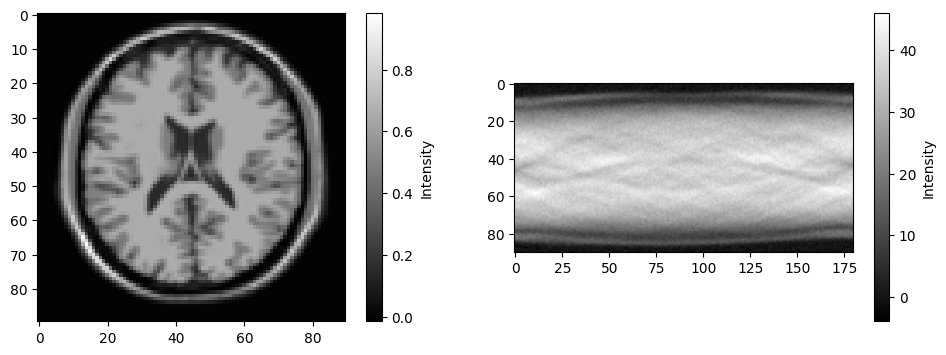

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.colorbar(axs[0].imshow(x_bar_sinogram, cmap='gray'), ax=axs[0], label='Intensity')
fig.colorbar(axs[1].imshow(y_sinogram, cmap='gray'), ax=axs[1], label='Intensity')
plt.show()
plt.close(fig)

## II. Optimization problem

In [48]:
def phi(x: np.ndarray) -> float:
    def phi_scalar(x: float) -> float:
        return np.sqrt(1 + x**2/delta**2)
    phi_vect = np.vectorize(phi_scalar)
    return phi_vect(x)

def phi_prime(x: np.ndarray) -> np.ndarray:
    def phi_prime_scalar(x: float) -> float:
        return x/((delta**2)*phi(x))
    phi_prime_vect = np.vectorize(phi_prime_scalar)
    return phi_prime_vect(x)

def phi_second(x: np.ndarray) -> np.ndarray:
    def phi_second_scalar(x: float) -> float:
        return (phi(x) - x * phi_prime(x))/(delta**2 * phi(x)**2)
    phi_second_vect = np.vectorize(phi_second_scalar)
    return phi_second_vect(x)

def r(x: np.ndarray, G:np.ndarray) -> float:
    return np.sum(phi(G @ x))

def grad_r(x: np.ndarray, G:np.ndarray) -> np.ndarray:
    return G.T @ phi_prime(G @ x)

def hessian_r(x: np.ndarray, G:np.ndarray) -> np.ndarray:
    return G.T @ np.diag(phi_second(G @ x).flatten()) @ G        

def f(x: np.ndarray, H: np.ndarray, G:np.ndarray, y:np.array) -> float:
    return 0.5 * np.linalg.norm(H @ x - y)**2 + lambda_ * r(x, G)

def grad_f(x: np.ndarray, H: np.ndarray, G: np.ndarray, y:np.array) -> np.ndarray:
    return H.T @ (H @ x - y) + lambda_ * grad_r(x, G)

def hessian_f(x: np.ndarray, H: np.ndarray,G:np.ndarray, y:np.array) -> np.ndarray:
    return H.T @ H + lambda_ * hessian_r(x, G)

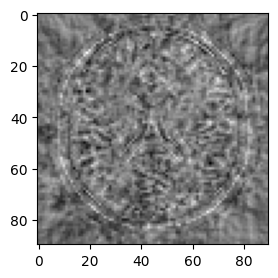

In [49]:
grad_test = grad_f(x_bar, H, G, y)
plt.figure(figsize=(3,3))
plt.imshow(grad_test.reshape((90, 90), order='F'), cmap='gray')
plt.show()
plt.close()

### Q3

## Optimization algorithms

In [50]:
x0 = np.zeros(N)
x0.flags.writeable = False

L = scipy.sparse.linalg.svds(H, k=1, return_singular_vectors=False)[0]**2 + (lambda_/delta**2) * scipy.sparse.linalg.svds(G, k=1, return_singular_vectors=False)[0]**2


### I. Gradient Descent

 50%|█████     | 2/4 [00:00<00:00,  5.51it/s]

Iter: 0, Grad Norm: 75010.31674757582


100%|██████████| 4/4 [00:00<00:00,  5.44it/s]


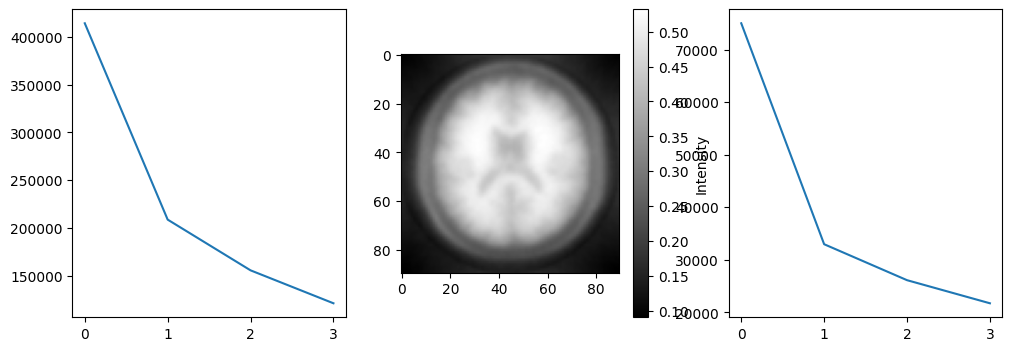

In [51]:
def grad_desc(x0: np.ndarray, eta: float, lambda_: float, delta: float, max_iter: int):
    x_gd = x0
    loss_history = []
    grad_norm_history = []
    x_history = []
    n_iter = 0
    for i in tqdm(range(max_iter)):
    # while np.linalg.norm(grad_f(x_gd, H, G, y)) > 1 * np.sqrt(N):
        x_gd = x_gd - eta*grad_f(x_gd, H, G, y) 
        loss_history.append(f(x_gd, H, G, y))
        x_history.append(x_gd)
        grad_norm_history.append(np.linalg.norm(grad_f(x_gd, H, G, y)))
        # n_iter += 1
        if i%10 == 0:
            print(f'Iter: {n_iter}, Grad Norm: {grad_norm_history[-1]}')
    return x_gd, loss_history, x_history, grad_norm_history

eta = 1/L
max_iter = 4
x_gd, loss_history_gd, x_history_gd, grad_norm_history_gd = grad_desc(x0, eta, lambda_, delta, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_gd)
fig.colorbar(axs[1].imshow(x_gd.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_gd)
plt.show()
plt.close(fig)

### II. MM quadratic algorithm

In [52]:
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator, cg, eigsh, bicg


def A(x: np.ndarray) -> np.ndarray:
    d = np.full(N, L + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    A = LinearOperator((N, N), matvec=matvec, rmatvec=rmatvec)
    return A


def mm_algorithm(x0: np.ndarray, theta: float, max_iter: int): #theta cst over the iterations for now
    x = x0.copy()
    loss_history = []
    x_history = []
    grad_norm_history = []
    n_iter = 0
    for i in tqdm(range(max_iter)):
    # while np.linalg.norm(grad_f(x, H, G, y)) > 1 * np.sqrt(N):
        grad_mm = grad_f(x, H, G, y)
        A_mm = A(x)
        v, info = bicg(A_mm, grad_mm)
        if info != 0:
            raise ValueError ("CG did not converge")
        
        x = x - theta*v 
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        # n_iter += 1
        if i%20 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
    return x, loss_history, x_history, grad_norm_history

100%|██████████| 30/30 [00:03<00:00,  9.16it/s]


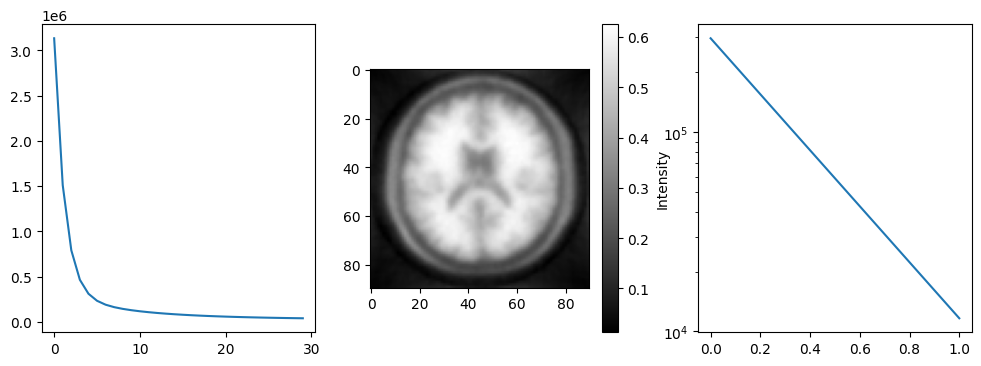

In [53]:
theta = 0.4
max_iter = 30
x_mm, loss_history_mm, x_history_mm, grad_norm_history_mm = mm_algorithm(x0, theta, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_mm)
fig.colorbar(axs[1].imshow(x_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_mm)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

In [54]:
def mg_algo(x0: np.ndarray, max_iter: int) -> np.ndarray:
    x = x0.copy()
    loss_history = []
    x_history = []
    grad_norm_history = []
    D = np.zeros((N, 2))
    for i in tqdm(range(max_iter)):
        D[:,0] = -grad_f(x, H, G, y)
        A3mg = A(x)
        u = -np.linalg.pinv(D.T @ A3mg @ D) @ (D.T @ grad_f(x, H, G, y))
        x += D @ u
        D[:,1] = D @ u
        loss_history.append(f(x, H, G, y))
        x_history.append(x)
        if i%20 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
    return x, loss_history, x_history, grad_norm_history

In [63]:
x0 = np.zeros(N)
x0.flags.writeable = False
max_iter = 3
x_3mg, loss_history_3mg, x_history_3mg, grad_norm_history_3mg = mg_algo(x0, max_iter)
x0

  0%|          | 0/3 [00:00<?, ?it/s]


ValueError: output array is read-only

100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


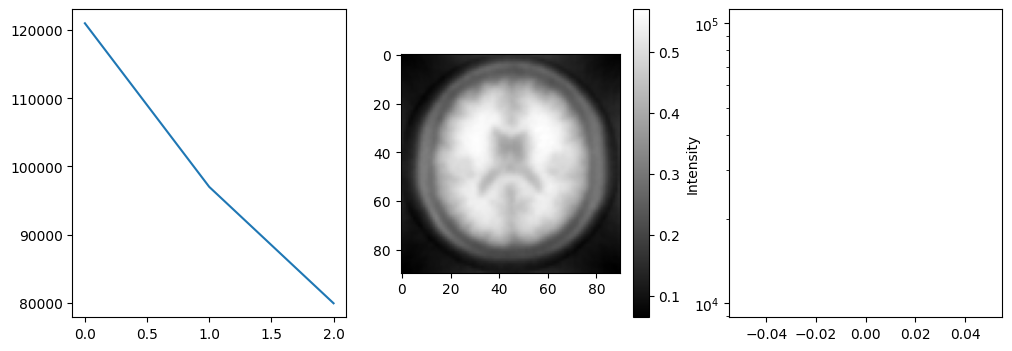

In [56]:
max_iter = 3
x_3mg, loss_history_3mg, x_history_3mg, grad_norm_history_3mg = mg_algo(x0, max_iter)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_3mg)
fig.colorbar(axs[1].imshow(x_3mg.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_3mg)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

In [57]:
x0

array([0.06622932, 0.06673912, 0.06909946, ..., 0.07047879, 0.06884327,
       0.06636433], shape=(8100,))

### IV. Block coordinate MM quadratic algorithm

In [58]:
def Aj(x: np.ndarray, Nj:int) -> np.ndarray:
    d = np.full(Nj, L + 1)      # check that 1 is a good margin
    curvature = diags(d).tocsc()

    def matvec(v):
        return curvature @ v
    
    def rmatvec(v):
        return curvature.T @ v
    
    Aj = LinearOperator((Nj, Nj), matvec=matvec, rmatvec=rmatvec)

    return Aj


def block_mm(x0: np.array, theta: float, max_iter: int, J:int) -> np.array:
    x = x0.copy()
    Nj = N//J
    x_history = []
    loss_history = []
    grad_norm_history = []
    n_iter = 0
    # while np.linalg.norm(grad_f(x, H, G, y)) > 1 * np.sqrt(N):
    for i in tqdm(range(max_iter)):
        j = i%J
        indices = range(Nj*j, Nj*(j+1))
        Hj = H[indices, :][:, indices]
        Gj = G[indices, :][:, indices]
        yj = y[indices]
        xj = x[indices]
        Aj_mm = Aj(x, Nj)
        gradj = grad_f(xj, Hj, Gj, yj)
        v, info = cg(Aj_mm, gradj)
        if info != 0:
            raise ValueError("Conjugate gradient solver did not converge")
        x[indices] = xj - theta*v       
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        if i%10 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter: {i}, Grad Norm: {grad_norm_history[-1]}')
    return x, loss_history, x_history, grad_norm_history

 15%|█▌        | 3/20 [00:00<00:01, 10.53it/s]

Iter: 0, Grad Norm: 14518.463734874947


 65%|██████▌   | 13/20 [00:01<00:00, 12.62it/s]

Iter: 10, Grad Norm: 10339.150209212037


100%|██████████| 20/20 [00:01<00:00, 13.00it/s]


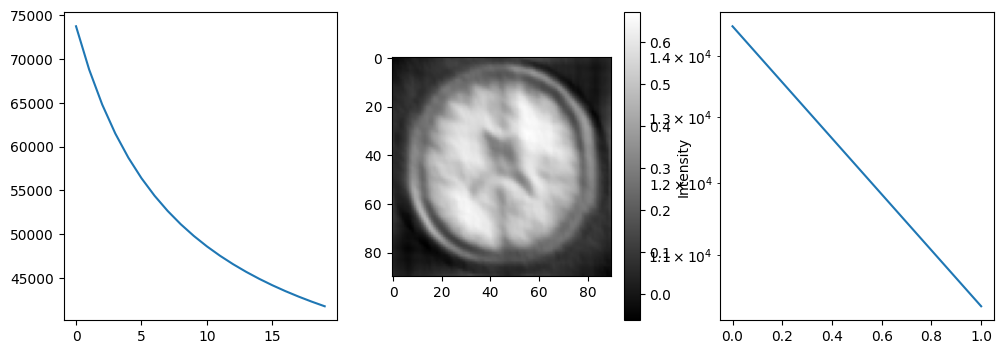

In [59]:
theta = 1
max_iter = 20
J = 1
x_block_mm, loss_history_block_mm, x_history_block_mm, grad_norm_history_block_mm = block_mm(x0, theta, max_iter, J)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_block_mm)
fig.colorbar(axs[1].imshow(x_block_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_block_mm)
axs[2].set_yscale('log')
plt.show()
plt.close(fig)

### V. Parallel MM quadratic algorithm

In [60]:
def phi_prime_over_id(x: np.ndarray) -> np.ndarray:
    def phi_prime_over_id_scalar(x: float) -> float:
        return x/((delta**2)*phi(x))
    phi_prime_over_id_vect = np.vectorize(phi_prime_over_id_scalar)
    return phi_prime_over_id_vect(x)

row_sums_H = H @ np.ones(N)
row_sums_G = G @ np.ones(N)
cal_H = H.T @ np.diag(row_sums_H)
cal_H = csr_matrix(cal_H) 
cal_G = G.T @ np.diag(row_sums_G)
cal_G = csr_matrix(cal_G) 

def B(x: np.ndarray) -> np.ndarray:
    b = cal_H @ np.ones(M) + lambda_ * cal_G @ phi_prime_over_id(G @ x)
    b = diags(b).tocsc()

    def matvec(v):
        return b @ v
    
    def rmatvec(v):
        return b.T @ v
    
    B = LinearOperator((N, N), matvec=matvec, rmatvec=rmatvec)
    return B

In [61]:
def parallel_mm_algo(x0, theat: float, max_iter: int):
    x = x0.copy()
    x_history = []
    loss_history = []
    grad_norm_history = []
    n_iter = 0
    for i in tqdm(range(max_iter)):
        B_mm = B(x)
        grad_mm = grad_f(x, H, G, y)
        v, info = cg(B_mm, grad_mm)
        if info != 0:
            raise ValueError("Conjugate gradient solver did not converge")
        x -= theta*v
        x_history.append(x)
        loss_history.append(f(x, H, G, y))
        if i%10 == 0:
            grad_norm_history.append(np.linalg.norm(grad_f(x, H, G, y)))
            print(f'Iter: {i}, Grad Norm: {grad_norm_history[-1]}')
    return x, loss_history, x_history, grad_norm_history

  8%|▊         | 2/25 [00:00<00:05,  4.31it/s]

Iter: 0, Grad Norm: 7512.184896910544


 48%|████▊     | 12/25 [00:02<00:02,  4.86it/s]

Iter: 10, Grad Norm: 2994.338590997636


 88%|████████▊ | 22/25 [00:04<00:00,  4.82it/s]

Iter: 20, Grad Norm: 1949.5783197222022


100%|██████████| 25/25 [00:05<00:00,  4.98it/s]


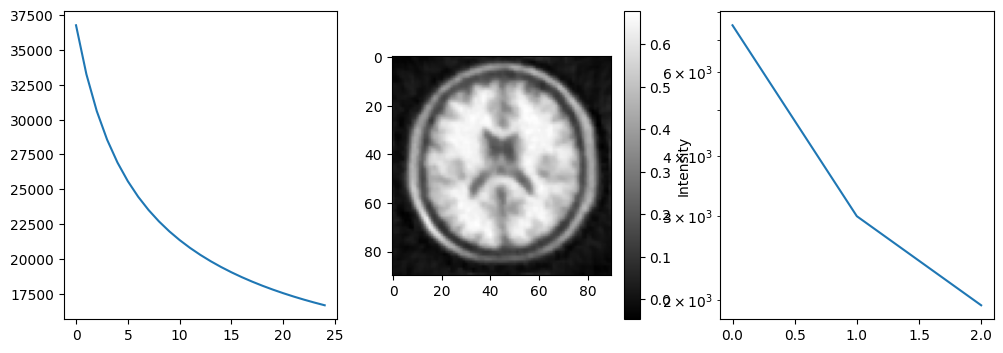

In [62]:
theta = 1
max_iter = 25
x_parallel_mm, loss_history_parallel_mm, x_history_parallel_mm, grad_norm_history_parallel_mm = parallel_mm_algo(x0, theta, max_iter) 

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(loss_history_parallel_mm)
fig.colorbar(axs[1].imshow(x_parallel_mm.reshape((90,90), order='F'), cmap='gray'), ax=axs[1], label='Intensity')
axs[2].plot(grad_norm_history_parallel_mm)
axs[2].set_yscale('log')
axs[2].yaxis.set_label_position("right")
plt.show()
plt.close(fig)